In [1]:
import EEGAnalysis as ea
import h5py
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import re, os
from tqdm import tqdm

In [8]:
dataset = ea.DataManager('/home/yizhan/storage/EEG/Data')

patient_id = 'zhouchen'
patient = dataset.get_patient(patient_id)

In [9]:
_behavior = pd.read_csv('../Step_3_Behavior_Stat/zhouchen-behavior-final.csv', dtype={'date':'str'})
check_behavior_prediction = lambda x,y,z: _behavior.time[(_behavior.paradigm == x) & (_behavior['date'] == y)].values < z
_behavior.head()

,date,paradigm,time,trial
0,180827,1-10,0.52,1
1,180827,1-10,0.32,2
2,180827,1-10,-0.44,3
3,180827,1-10,-0.12,4
4,180827,1-10,-0.04,5


In [10]:
_freq = 2000
ROI = (-3, 3)
# frange = np.logspace(np.log10(10), np.log10(150), 40)
frange = np.logspace(np.log10(1), np.log10(150), 40)
zbase = (-2,-1)
tspec = np.linspace(ROI[0], ROI[1], int(_freq)*(ROI[1]-ROI[0]))


nyq = _freq / 2.0
width = 5.0 / nyq
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

taps = signal.firwin(N, [0.5/nyq, 2/nyq],window=('kaiser', beta),pass_zero=False)

# _filted = signal.filtfilt(taps, 1, _data)
# _hilbert_pwr = np.abs(signal.hilbert(_filted))

In [11]:
data_list = patient.load_isplit(8)
_dates = data_list.keys()

In [13]:
sample = data_list['180901-1']
_m = patient.get_marker(file='180901-1', paradigm='1-5')
_m
quartile = _m[:20].reshape((-1,5))
# tspec = np.linspace((_m[0] - 10), (_m[-1] + 20), int((_m[-1] - _m[0] + 30) * _freq))
_b = _behavior.time[(_behavior.date == '180901') & (_behavior.paradigm == '1-5')].values
_b

array([ 0.68, -0.2 , -0.12, -0.04,  0.  ,  0.12,  0.28, -0.2 , -0.04,
        0.12,  0.12,  0.08, -0.32, -0.32, -0.4 ,  0.12, -0.12,  0.12,
       -0.28, -0.2 ])

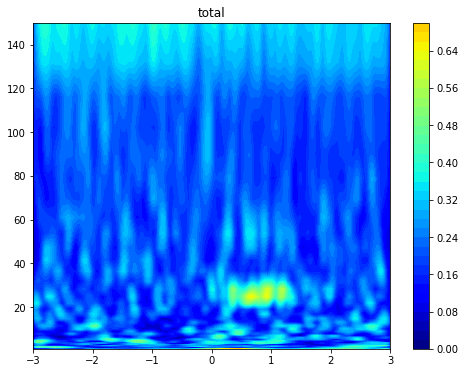

In [14]:
_epoch = ea.create_1d_epoch_bymarker(sample['value'], _m[:20]+_b, ROI, int(_freq))
_entry_dwt = ea.dwt.dwt(_epoch, int(_freq), frange, reflection=True)
# entry_power = ea.decomposition.dwt_power(_entry_dwt, _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))

entry_itpc = ea.decomposition.dwt_itpc(_entry_dwt)

_smooth = np.zeros_like(entry_itpc)
for idx in range(len(entry_itpc)):
    _smooth[idx] = ea.decomposition.gaussianwind(entry_itpc[idx,:], int(_freq), 0.05)
    
plt.figure(figsize=(8,6))
plt.contourf(tspec, frange, _smooth, 40, cmap=plt.get_cmap('jet'))
plt.clim((0,1))
plt.title('total')
plt.colorbar()
plt.show()

In [30]:
def _plot_c(entry, marker, name='', dsig=3, _filter=None):
    entry_result = np.zeros((np.size(frange), np.size(tspec)))
    
    for idx in range(len(entry)):
        _epoch = ea.create_1d_epoch_bymarker(entry[idx], marker[idx], ROI, int(_freq))
        if isinstance(_filter, type(None)):
            _entry_dwt = ea.dwt.dwt(_epoch, int(_freq), frange, reflection=True)
        else:
            _entry_dwt = ea.dwt.dwt(_epoch[_filter[idx]], int(_freq), frange, reflection=True)
            
        entry_result += ea.decomposition.dwt_power(_entry_dwt, _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))

    entry_result /= len(entry)
#     entry_result = ea.decomposition.dwt_itpc(_entry_dwt)

    _smooth = np.zeros_like(entry_result)
    for idx in range(len(entry_result)):
        _smooth[idx] = ea.decomposition.gaussianwind(entry_result[idx,:], int(_freq), 0.05)

    plt.contourf(tspec, frange, _smooth, 80, cmap=plt.get_cmap('jet'))
    plt.clim(-dsig*np.std(_smooth), dsig*np.std(_smooth))
    plt.title(name)


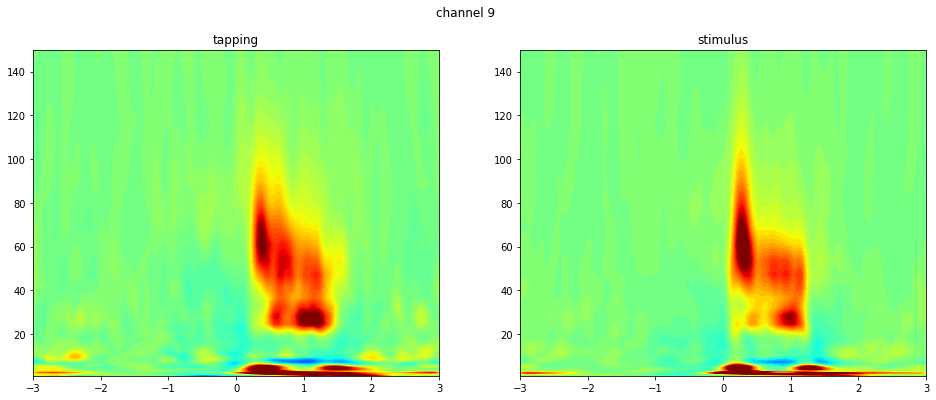

In [31]:
chidx = 9
data_list = patient.load_isplit(chidx)


_values = [item['value'] for key, item in data_list.items() if key[-1] == '1']

_mb = [patient.get_marker(file=item, paradigm='1-5') + _behavior.time[(_behavior.date == item[:6]) & (_behavior.paradigm == '%s-5'%item[-1])].values 
 for item in _dates if item[-1] == '1']

_m = [patient.get_marker(file=item, paradigm='1-5') for item in _dates if item[-1] == '1']

_p = [check_behavior_prediction('1-5', item[:6], 0) for item in _dates if item[-1] == '1']

# sample = data_list['180901-1']
# _m = patient.get_marker('180901-1', '1-5')
# _b = _behavior.time[(_behavior.date == '180901') & (_behavior.paradigm == '1-5')].values

plt.figure(figsize=(8*2,6))

plt.subplot(1,2,1)
# _plot_c(sample['value'], _m[:20]+_b, 'tapping', 3)
_plot_c(_values, _mb, 'tapping', 3, _p)

plt.subplot(1,2,2)
# _plot_c(sample['value'], _m[:20], 'stimulus', 3)
_plot_c(_values, _m, 'stimulus', 3)

plt.suptitle('channel %d'%chidx)
plt.show()